In [6]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import holidays

In [7]:
# Load your time series data
df = pd.read_csv('2223TaftLSTM.csv')
df.tail(5)

Day        Date   Time          DateAndTime  Entry  is_weekend  \
14595  Sunday  12/31/2023  19:00  31.12.2023 19.00.00   1681           1   
14596  Sunday  12/31/2023  20:00  31.12.2023 20.00.00    297           1   
14597  Sunday  12/31/2023  21:00  31.12.2023 21.00.00      0           1   
14598  Sunday  12/31/2023  22:00  31.12.2023 22.00.00      0           1   
14599  Sunday  12/31/2023  23:00  31.12.2023 23.00.00      0           1   

       rain_class  rain_amount rain_desc  
14595           0          0.0   No Rain  
14596           0          0.0   No Rain  
14597           0          0.0   No Rain  
14598           0          0.0   No Rain  
14599           0          0.0   No Rain

In [8]:
ph_holidays = holidays.PH()
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x in ph_holidays else 0)
df.head(5)

Day        Date  Time          DateAndTime  Entry  is_weekend  \
0  Saturday  01/01/2022  4:00  01.01.2022 04.00.00      0           1   
1  Saturday  01/01/2022  5:00  01.01.2022 05.00.00      0           1   
2  Saturday  01/01/2022  6:00  01.01.2022 06.00.00    525           1   
3  Saturday  01/01/2022  7:00  01.01.2022 07.00.00    610           1   
4  Saturday  01/01/2022  8:00  01.01.2022 08.00.00    684           1   

   rain_class  rain_amount rain_desc  is_holiday  
0           0          0.0   No Rain           1  
1           0          0.0   No Rain           1  
2           0          0.0   No Rain           1  
3           0          0.0   No Rain           1  
4           0          0.0   No Rain           1

In [9]:
df.drop(['Date', 'Time', 'rain_amount', 'rain_desc'], axis=1, inplace=True)
df.head(31)

Day          DateAndTime  Entry  is_weekend  rain_class  is_holiday
0   Saturday  01.01.2022 04.00.00      0           1           0           1
1   Saturday  01.01.2022 05.00.00      0           1           0           1
2   Saturday  01.01.2022 06.00.00    525           1           0           1
3   Saturday  01.01.2022 07.00.00    610           1           0           1
4   Saturday  01.01.2022 08.00.00    684           1           0           1
5   Saturday  01.01.2022 09.00.00    770           1           0           1
6   Saturday  01.01.2022 10.00.00   1022           1           0           1
7   Saturday  01.01.2022 11.00.00   1248           1           0           1
8   Saturday  01.01.2022 12.00.00   1048           1           0           1
9   Saturday  01.01.2022 13.00.00   1199           1           0           1
10  Saturday  01.01.2022 14.00.00   1174           1           0           1
11  Saturday  01.01.2022 15.00.00   1249           1           0           1
12  Saturday  01.01.2022 16.00.00   1385           1           0           1
13  Saturday  01.01.2022 17.00.00   1332           1           0           1
14  Saturday  01.01.2022 18.00.00   1401           1           0           1
15  Saturday  01.01.2022 19.00.00   1322           1           0           1
16  Saturday  01.01.2022 20.00.00   1033           1           0           1
17  Saturday  01.01.2022 21.00.00    790           1           0           1
18  Saturday  01.01.2022 22.00.00     71           1           0           1
19  Saturday  01.01.2022 23.00.00      0           1           0           1
20    Sunday  02.01.2022 04.00.00      0           1           0           0
21    Sunday  02.01.2022 05.00.00    602           1           0           0
22    Sunday  02.01.2022 06.00.00    676           1           0           0
23    Sunday  02.01.2022 07.00.00    853           1           0           0
24    Sunday  02.01.2022 08.00.00    972           1           0           0
25    Sunday  02.01.2022 09.00.00   1232           1           0           0
26    Sunday  02.01.2022 10.00.00   1236           1           0           0
27    Sunday  02.01.2022 11.00.00   1391           1           0           0
28    Sunday  02.01.2022 12.00.00   1452           1           0           0
29    Sunday  02.01.2022 13.00.00   1606           1           0           0
30    Sunday  02.01.2022 14.00.00   1632           1           0           0

In [10]:
df['Date Time'] = pd.to_datetime(df['DateAndTime'], format='%d.%m.%Y %H.%M.%S')
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year
df.drop(['DateAndTime', 'Day', 'is_weekend'], axis=1, inplace=True)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

model_features = ['hour', 'day_of_week', 'is_weekend','is_holiday', 'month', 'year', 'rain_class']
df_model = df[model_features]

df.head(30)

Entry  rain_class  is_holiday           Date Time  hour  day_of_week  \
0       0           0           1 2022-01-01 04:00:00     4            5   
1       0           0           1 2022-01-01 05:00:00     5            5   
2     525           0           1 2022-01-01 06:00:00     6            5   
3     610           0           1 2022-01-01 07:00:00     7            5   
4     684           0           1 2022-01-01 08:00:00     8            5   
5     770           0           1 2022-01-01 09:00:00     9            5   
6    1022           0           1 2022-01-01 10:00:00    10            5   
7    1248           0           1 2022-01-01 11:00:00    11            5   
8    1048           0           1 2022-01-01 12:00:00    12            5   
9    1199           0           1 2022-01-01 13:00:00    13            5   
10   1174           0           1 2022-01-01 14:00:00    14            5   
11   1249           0           1 2022-01-01 15:00:00    15            5   
12   1385           0           1 2022-01-01 16:00:00    16            5   
13   1332           0           1 2022-01-01 17:00:00    17            5   
14   1401           0           1 2022-01-01 18:00:00    18            5   
15   1322           0           1 2022-01-01 19:00:00    19            5   
16   1033           0           1 2022-01-01 20:00:00    20            5   
17    790           0           1 2022-01-01 21:00:00    21            5   
18     71           0           1 2022-01-01 22:00:00    22            5   
19      0           0           1 2022-01-01 23:00:00    23            5   
20      0           0           0 2022-01-02 04:00:00     4            6   
21    602           0           0 2022-01-02 05:00:00     5            6   
22    676           0           0 2022-01-02 06:00:00     6            6   
23    853           0           0 2022-01-02 07:00:00     7            6   
24    972           0           0 2022-01-02 08:00:00     8            6   
25   1232           0           0 2022-01-02 09:00:00     9            6   
26   1236           0           0 2022-01-02 10:00:00    10            6   
27   1391           0           0 2022-01-02 11:00:00    11            6   
28   1452           0           0 2022-01-02 12:00:00    12            6   
29   1606           0           0 2022-01-02 13:00:00    13            6   

    month  year  is_weekend  
0       1  2022           1  
1       1  2022           1  
2       1  2022           1  
3       1  2022           1  
4       1  2022           1  
5       1  2022           1  
6       1  2022           1  
7       1  2022           1  
8       1  2022           1  
9       1  2022           1  
10      1  2022           1  
11      1  2022           1  
12      1  2022           1  
13      1  2022           1  
14      1  2022           1  
15      1  2022           1  
16      1  2022           1  
17      1  2022           1  
18      1  2022           1  
19      1  2022           1  
20      1  2022           1  
21      1  2022           1  
22      1  2022           1  
23      1  2022           1  
24      1  2022           1  
25      1  2022           1  
26      1  2022           1  
27      1  2022           1  
28      1  2022           1  
29      1  2022           1

In [11]:
# Display the DataFrame before normalization
print(df_model.dtypes)
df_model.head(30)


hour           int32
day_of_week    int32
is_weekend     int64
is_holiday     int64
month          int32
year           int32
rain_class     int64
dtype: object


hour  day_of_week  is_weekend  is_holiday  month  year  rain_class
0      4            5           1           1      1  2022           0
1      5            5           1           1      1  2022           0
2      6            5           1           1      1  2022           0
3      7            5           1           1      1  2022           0
4      8            5           1           1      1  2022           0
5      9            5           1           1      1  2022           0
6     10            5           1           1      1  2022           0
7     11            5           1           1      1  2022           0
8     12            5           1           1      1  2022           0
9     13            5           1           1      1  2022           0
10    14            5           1           1      1  2022           0
11    15            5           1           1      1  2022           0
12    16            5           1           1      1  2022           0
13    17            5           1           1      1  2022           0
14    18            5           1           1      1  2022           0
15    19            5           1           1      1  2022           0
16    20            5           1           1      1  2022           0
17    21            5           1           1      1  2022           0
18    22            5           1           1      1  2022           0
19    23            5           1           1      1  2022           0
20     4            6           1           0      1  2022           0
21     5            6           1           0      1  2022           0
22     6            6           1           0      1  2022           0
23     7            6           1           0      1  2022           0
24     8            6           1           0      1  2022           0
25     9            6           1           0      1  2022           0
26    10            6           1           0      1  2022           0
27    11            6           1           0      1  2022           0
28    12            6           1           0      1  2022           0
29    13            6           1           0      1  2022           0

In [12]:
from sklearn.preprocessing import MinMaxScaler
import joblib

df_model = df[model_features + ['Entry']]

# Normalize all features except 'Entry'
scaler = MinMaxScaler(feature_range=(0, 1))
df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])

# Save the scaler for the features
joblib.dump(scaler, 'model/scaler_features.pkl')

# Ensure 'Entry' column exists in df_model
if 'Entry' in df_model.columns:
    # Normalize the 'Entry' column separately
    scaler_entry = MinMaxScaler(feature_range=(0, 1))
    df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])
    
    # Save the scaler for the 'Entry' column
    joblib.dump(scaler_entry, 'model/scaler_entry.pkl')
else:
    print("Error: 'Entry' column not found in df_model")


C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_15032\1949296345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])
C:\Users\inspiron-7460\AppData\Local\Temp\ipykernel_15032\1949296345.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])


In [13]:
# Display the DataFrame after normalization
print("After normalization:")
df_model.head(20)

After normalization:


hour  day_of_week  is_weekend  is_holiday  month  year  rain_class  \
0   0.000000     0.833333         1.0         1.0    0.0   0.0         0.0   
1   0.052632     0.833333         1.0         1.0    0.0   0.0         0.0   
2   0.105263     0.833333         1.0         1.0    0.0   0.0         0.0   
3   0.157895     0.833333         1.0         1.0    0.0   0.0         0.0   
4   0.210526     0.833333         1.0         1.0    0.0   0.0         0.0   
5   0.263158     0.833333         1.0         1.0    0.0   0.0         0.0   
6   0.315789     0.833333         1.0         1.0    0.0   0.0         0.0   
7   0.368421     0.833333         1.0         1.0    0.0   0.0         0.0   
8   0.421053     0.833333         1.0         1.0    0.0   0.0         0.0   
9   0.473684     0.833333         1.0         1.0    0.0   0.0         0.0   
10  0.526316     0.833333         1.0         1.0    0.0   0.0         0.0   
11  0.578947     0.833333         1.0         1.0    0.0   0.0         0.0   
12  0.631579     0.833333         1.0         1.0    0.0   0.0         0.0   
13  0.684211     0.833333         1.0         1.0    0.0   0.0         0.0   
14  0.736842     0.833333         1.0         1.0    0.0   0.0         0.0   
15  0.789474     0.833333         1.0         1.0    0.0   0.0         0.0   
16  0.842105     0.833333         1.0         1.0    0.0   0.0         0.0   
17  0.894737     0.833333         1.0         1.0    0.0   0.0         0.0   
18  0.947368     0.833333         1.0         1.0    0.0   0.0         0.0   
19  1.000000     0.833333         1.0         1.0    0.0   0.0         0.0   

       Entry  
0   0.000000  
1   0.000000  
2   0.082121  
3   0.095417  
4   0.106992  
5   0.120444  
6   0.159862  
7   0.195214  
8   0.163929  
9   0.187549  
10  0.183638  
11  0.195370  
12  0.216643  
13  0.208353  
14  0.219146  
15  0.206789  
16  0.161583  
17  0.123573  
18  0.011106  
19  0.000000

In [14]:
print("After normalization:")
print(df_model.dtypes)

After normalization:
hour           float64
day_of_week    float64
is_weekend     float64
is_holiday     float64
month          float64
year           float64
rain_class     float64
Entry          float64
dtype: object


<Axes: >

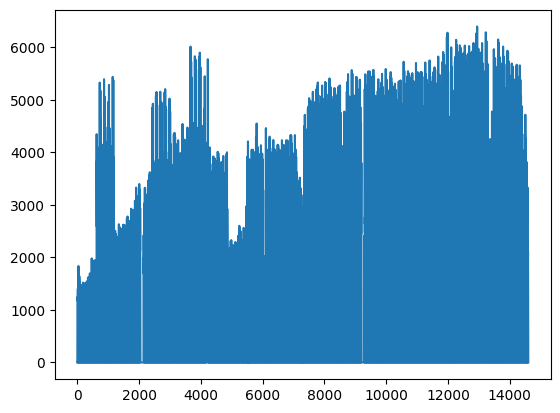

In [15]:
entry = df['Entry']
entry.plot()

In [16]:
def df_to_X_y(df, window_size=20):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][7]  # 'Entry' is the 8th column (index 7)
        y.append(label)
    return np.array(X), np.array(y)

In [17]:
X, y = df_to_X_y(df_model)
X.shape, y.shape

((14580, 20, 8), (14580,))

In [18]:
# Determine the split points
train_split_point = int(len(X) * 0.8)
valntest_split_point = int(len(X) * 0.9)

# Split the data
X_train, X_val, X_test = X[:train_split_point], X[train_split_point:valntest_split_point], X[valntest_split_point:]
y_train, y_val, y_test = y[:train_split_point], y[train_split_point:valntest_split_point], y[valntest_split_point:]

# Print the shapes to verify the splits
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11664, 20, 8), (11664,), (1458, 20, 8), (1458,), (1458, 20, 8), (1458,))

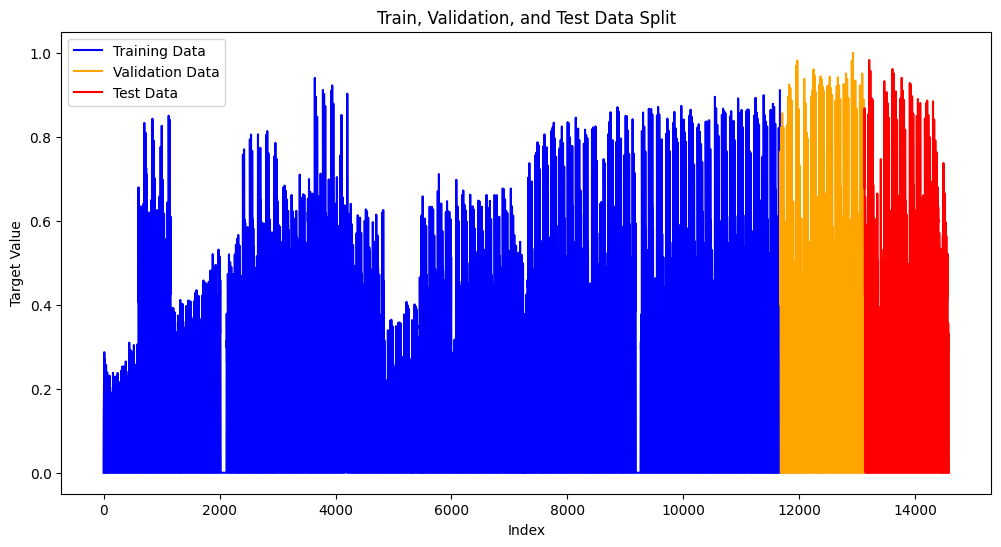

In [19]:
import matplotlib.pyplot as plt
# Visualization

date_time = df['Date Time']
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(range(train_split_point), y_train, label='Training Data', color='blue')

# Plot the validation data
plt.plot(range(train_split_point, valntest_split_point), y_val, label='Validation Data', color='orange')

# Plot the test data
plt.plot(range(valntest_split_point, len(X)), y_test, label='Test Data', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Train, Validation, and Test Data Split')
plt.legend()

# Show the plot
plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])


Epoch 1/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0332 - val_loss: 0.0110
Epoch 2/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 3/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 4/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 5/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 6/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 7/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 11/100
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 12/100
365/365

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go

# Extract the 'Date Time' column for the test set
date_time_test = df['Date Time'][-len(y_test):]  # Use the date time series for the test set

# Load the scaler for inverse transformation
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Check the length of y_pred to ensure it matches y_test
#print(f"Length of y_pred: {len(y_pred)}")
#print(f"Length of y_test: {len(y_test)}")

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y_test, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
# Calculate adjusted R-squared
n = len(y_test)
p = X_test.shape[2]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=date_time_test, y=y_true_inv.flatten(), mode='lines', name='Actual Test Values'))
fig.add_trace(go.Scatter(x=date_time_test, y=y_pred_inv.flatten(), mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Test Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Root Mean Squared Error (RMSE): 304.866057076221
Mean Absolute Error (MAE): 184.5761316872428
R-squared (R²): 0.9493108466954338
Adjusted R-squared: 0.9490309893963057


In [24]:
print(f"Length of the dataset: {len(X)}")

# Make predictions on the entire dataset
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_true_inv = scaler_entry.inverse_transform(df_actual)

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_true_inv = np.round(np.maximum(y_true_inv, 0))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)
# Calculate adjusted R-squared
n = len(y_test)
p = X_test.shape[2]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

# Create a DataFrame with all features and the true and forecasted values
df_features_with_predictions = df.iloc[-len(y_true_inv):].copy()

# Rename the 'Entry' column to 'Actual Values'
df_features_with_predictions.rename(columns={'Entry': 'Actual Values'}, inplace=True)

# Add the 'Forecasted Values' column
df_features_with_predictions['Forecasted Values'] = y_pred_inv.flatten()

# Reorder the columns
df_features_with_predictions = df_features_with_predictions[['Date Time', 'hour', 'day_of_week', 'is_weekend', 'is_holiday', 'month', 'year', 'rain_class', 'Actual Values', 'Forecasted Values']]

# Plot the results with 'Date Time' as the x-axis using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Actual Values'], mode='lines', name='Actual Values'))
fig.add_trace(go.Scatter(x=df_features_with_predictions['Date Time'], y=df_features_with_predictions['Forecasted Values'], mode='lines', name='Forecasted Values'))

fig.update_layout(title='LSTM Model Forecast vs Actual Values', xaxis_title='Date Time', yaxis_title='Entry', legend_title='Legend')

fig.show()

Length of the dataset: 14580
456/456 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Root Mean Squared Error (RMSE): 212.06661689195684
Mean Absolute Error (MAE): 137.05493827160493
R-squared (R²): 0.9727740922833058
Adjusted R-squared: 0.9726237767127512


In [25]:
import plotly.express as px

# Group the data by hour and calculate the mean for Actual Values and Forecasted Values
hourly_trends = df_features_with_predictions.groupby('hour')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Display the hourly trends DataFrame
print(hourly_trends)

# Plot the hourly trends using Plotly
fig = px.line(hourly_trends, x='hour', y=['Actual Values', 'Forecasted Values'], title='Hourly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Hour of the Day',
    yaxis_title='Entry',
    legend_title='Legend'
)

# Show the plot
fig.show()

    hour  Actual Values  Forecasted Values
0      4       3.098765           4.842250
1      5    1967.928669        1946.680420
2      6    3046.194787        3095.192139
3      7    3665.157750        3789.673584
4      8    3222.784636        3364.836670
5      9    2793.884774        2822.490967
6     10    2403.130316        2534.865479
7     11    2388.989026        2400.736572
8     12    2380.348422        2380.728516
9     13    2296.766804        2362.716064
10    14    2289.957476        2332.776367
11    15    2428.330590        2448.443115
12    16    2797.491084        2823.249756
13    17    3117.714678        3170.067139
14    18    2996.375857        3142.155029
15    19    2717.984911        2748.245605
16    20    2215.203018        2249.156494
17    21    1558.648834        1529.814819
18    22      72.432099          90.953362
19    23       0.189300          12.700960


In [26]:
# Group the data by day of the week and calculate the mean for Actual Values and Forecasted Values
daily_trends = df_features_with_predictions.groupby('day_of_week')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Sort the daily trends DataFrame to start with Sunday
daily_trends['day_of_week'] = daily_trends['day_of_week'].map({6: 'Sunday', 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday'})
daily_trends = daily_trends.set_index('day_of_week').reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']).reset_index()

# Plot the daily trends using Plotly
fig = px.line(daily_trends, x='day_of_week', y=['Actual Values', 'Forecasted Values'], title='Daily Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
        ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )
)

# Show the plot
fig.show()

In [27]:
import pandas as pd
import plotly.express as px

# Group the data by month and calculate the mean for Actual Values and Forecasted Values
yearly_trends = df_features_with_predictions.groupby('month')[['Actual Values', 'Forecasted Values']].mean().reset_index()

# Map the month numbers to month names
yearly_trends['month'] = yearly_trends['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Sort the DataFrame by month order
yearly_trends['month'] = pd.Categorical(yearly_trends['month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], ordered=True)
yearly_trends = yearly_trends.sort_values('month')

# Plot the yearly trends using Plotly
fig = px.line(yearly_trends, x='month', y=['Actual Values', 'Forecasted Values'], title='Yearly Trends of Entry Data')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Entry',
    legend_title='Legend',
    xaxis=dict(
        tickmode='array',
        tickvals=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ],
        ticktext=[
            'January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December'
        ]
    )
)

# Show the plot
fig.show()

In [28]:
# DO NOT RUN THIS!
'''from sklearn.model_selection import TimeSeriesSplit
# Cross-Validation
def time_series_cv(df_model, n_splits=5, window_size=19):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    all_rmse = []
    all_mae = []
    all_r2 = []
    
    for train_index, val_index in tscv.split(df_model):
        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]
        
        # Prepare data
        X_train, y_train = df_to_X_y(df_train, window_size)
        X_val, y_val = df_to_X_y(df_val, window_size)
        
        # Build the model
        model = Sequential()
        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='linear'))
        model.add(Dense(1, activation='linear'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the model
        model.fit(X_train, y_train, epochs=100, verbose=0)

        # Make predictions
        y_pred = model.predict(X_val)

        # Inverse transform the predictions and actual values
        df_pred = pd.DataFrame(y_pred, columns=['Entry'])
        df_actual = pd.DataFrame(y_val, columns=['Entry'])
        y_pred_inv = scaler_entry.inverse_transform(df_pred)
        y_true_inv = scaler_entry.inverse_transform(df_actual)

        # Round the predictions to the nearest whole number
        y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
        y_true_inv = np.round(np.maximum(y_true_inv, 0))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        r2 = r2_score(y_true_inv, y_pred_inv)

        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)

    return all_rmse, all_mae, all_r2

# Perform Time Series Cross-Validation
rmse_list, mae_list, r2_list = time_series_cv(df_model)

# Print the results
print("RMSE for each fold:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))
print("MAE for each fold:", mae_list)
print("Mean MAE:", np.mean(mae_list))
print("R-squared for each fold:", r2_list)
print("Mean R²:", np.mean(r2_list))'''

'from sklearn.model_selection import TimeSeriesSplit\n# Cross-Validation\ndef time_series_cv(df_model, n_splits=5, window_size=19):\n    tscv = TimeSeriesSplit(n_splits=n_splits)\n    \n    all_rmse = []\n    all_mae = []\n    all_r2 = []\n    \n    for train_index, val_index in tscv.split(df_model):\n        df_train, df_val = df_model.iloc[train_index], df_model.iloc[val_index]\n        \n        # Prepare data\n        X_train, y_train = df_to_X_y(df_train, window_size)\n        X_val, y_val = df_to_X_y(df_val, window_size)\n        \n        # Build the model\n        model = Sequential()\n        model.add(InputLayer((X_train.shape[1], X_train.shape[2])))\n        model.add(LSTM(64, return_sequences=True))\n        model.add(Dropout(0.2))\n        model.add(LSTM(64))\n        model.add(Dropout(0.2))\n        model.add(Dense(32, activation=\'linear\'))\n        model.add(Dense(1, activation=\'linear\'))\n\n        # Compile the model\n        model.compile(optimizer=\'adam\', loss=

In [29]:
# Calculate mean and standard deviation for holidays and non-holidays
mean_holiday = df[df['is_holiday'] == 1]['Entry'].mean()
std_holiday = df[df['is_holiday'] == 1]['Entry'].std()
mean_non_holiday = df[df['is_holiday'] == 0]['Entry'].mean()
std_non_holiday = df[df['is_holiday'] == 0]['Entry'].std()

print(f"Holiday - Mean: {mean_holiday}, Std Dev: {std_holiday}")
print(f"Non-Holiday - Mean: {mean_non_holiday}, Std Dev: {std_non_holiday}")

Holiday - Mean: 1571.4333333333334, Std Dev: 1183.7936624934073
Non-Holiday - Mean: 2255.610683139535, Std Dev: 1281.0460955878887


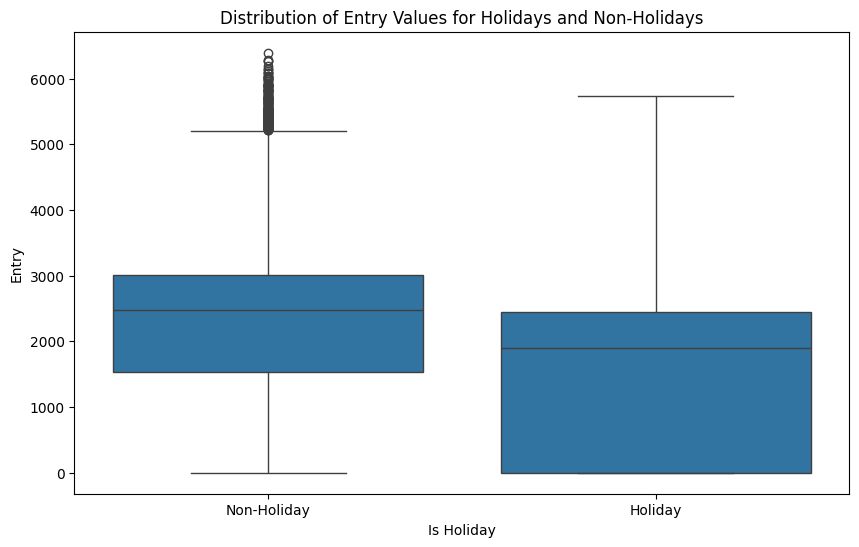

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot to visualize the distribution of Entry values for holidays and non-holidays
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Entry', data=df)
plt.title('Distribution of Entry Values for Holidays and Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Entry')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [31]:
from scipy.stats import ttest_ind

# Perform t-test
holiday_entries = df[df['is_holiday'] == 1]['Entry']
non_holiday_entries = df[df['is_holiday'] == 0]['Entry']

t_stat, p_value = ttest_ind(holiday_entries, non_holiday_entries, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between holidays and non-holidays.")

T-statistic: -16.1822346987373, P-value: 2.7881797500406995e-52
Reject the null hypothesis: There is a significant difference in Entry values between holidays and non-holidays.


In [32]:
# Calculate mean and standard deviation for each rain_class
rain_class_stats = df.groupby('rain_class')['Entry'].agg(['mean', 'std']).reset_index()
print(rain_class_stats)

   rain_class         mean          std
0           0  2152.946460  1280.615732
1           1  2170.555357  1282.641484
2           2  2348.489119  1288.242407
3           3  2261.762209  1283.576489
4           4  2103.809259  1270.281338
5           5  1112.050000   613.758265


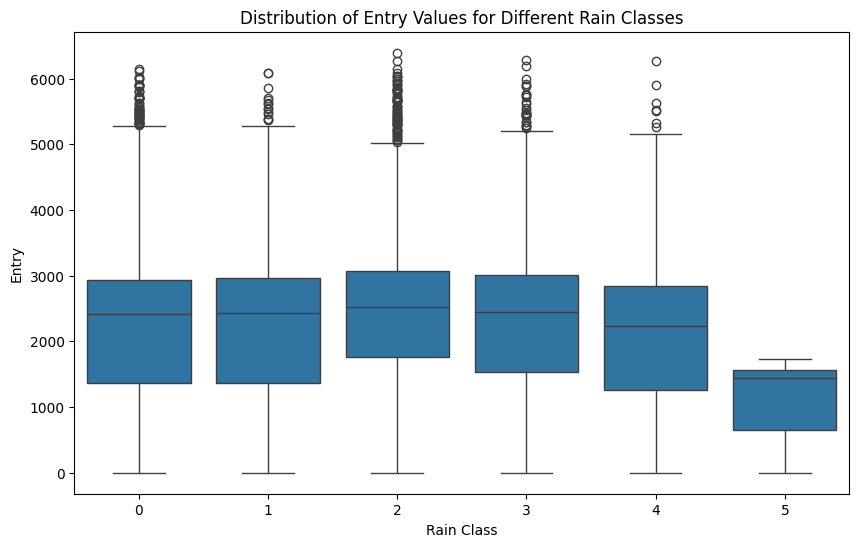

F-statistic: 16.174054433257506, P-value: 6.11984066972718e-16
Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.


In [33]:
# Box plot to visualize the distribution of Entry values for different rain classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='rain_class', y='Entry', data=df)
plt.title('Distribution of Entry Values for Different Rain Classes')
plt.xlabel('Rain Class')
plt.ylabel('Entry')
plt.show()

from scipy.stats import f_oneway

# Perform ANOVA
rain_class_groups = [df[df['rain_class'] == rc]['Entry'] for rc in df['rain_class'].unique()]
f_stat, p_value = f_oneway(*rain_class_groups)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Entry values between different rain classes.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Entry values between different rain classes.")

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------
     0      1    17.6089  0.996    -81.984  117.2018  False
     0      2   195.5427    0.0   121.8583   269.227   True
     0      3   108.8157 0.0208    10.1553  207.4762   True
     0      4   -49.1372 0.9565  -212.5389  114.2645  False
     0      5 -1040.8965 0.0039 -1859.2432 -222.5497   True
     1      2   177.9338    0.0    71.1219  284.7456   True
     1      3    91.2069 0.3011   -34.1457  216.5594  False
     1      4   -66.7461    0.9  -247.5208  114.0286  False
     1      5 -1058.5054 0.0033 -1880.4973 -236.5134   True
     2      3   -86.7269 0.1808  -192.6698    19.216  False
     2      4  -244.6799 0.0005   -412.579  -76.7807   True
     2      5 -1236.4391 0.0002 -2055.6957 -417.1825   True
     3      4   -157.953 0.1248  -338.2156   22.3097  False
     3      5 -1149.7122  0.001 -1971.59

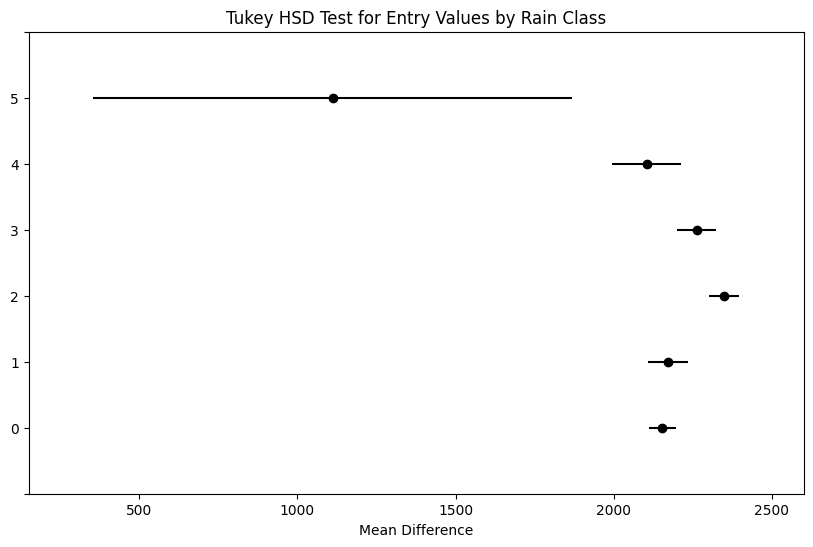

In [34]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Entry'], groups=df['rain_class'], alpha=0.05)
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test for Entry Values by Rain Class')
plt.xlabel('Mean Difference')
plt.show()

In [35]:
import numpy as np
import shap

# Create a background dataset for SHAP using a larger sample from the training set
background = X[np.random.choice(X.shape[0], min(7000, X.shape[0]), replace=False)]

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the entire test dataset
shap_values = explainer.shap_values(X)  # Use the entire test dataset

# Check the shape of shap_values
print("Original SHAP values shape:", shap_values.shape)

# Reshape the SHAP values to (n_samples, n_timesteps, n_features)
shap_values_flat = shap_values.reshape(X.shape[0], 20, -1)
print("Reshaped SHAP values shape:", shap_values_flat.shape)

# Average across the time steps
shap_values_avg = np.mean(shap_values_flat, axis=1)  # Now the shape will be (n_samples, n_features)
print("Averaged SHAP values shape:", shap_values_avg.shape)

# Prepare X_test for plotting (only keep the features excluding 'Entry')
X_test_flat = X[:, -1, :-1]  # Take the last time step and exclude 'Entry'
print("X_test_flat shape:", X_test_flat.shape)

# Ensure the number of features matches (we will take only the first 7 features for SHAP)
shap_values_avg = shap_values_avg[:, :-1]  # Exclude the last feature to match


c:\Users\inspiron-7460\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']



Original SHAP values shape: (14580, 20, 8, 1)
Reshaped SHAP values shape: (14580, 20, 8)
Averaged SHAP values shape: (14580, 8)
X_test_flat shape: (14580, 7)


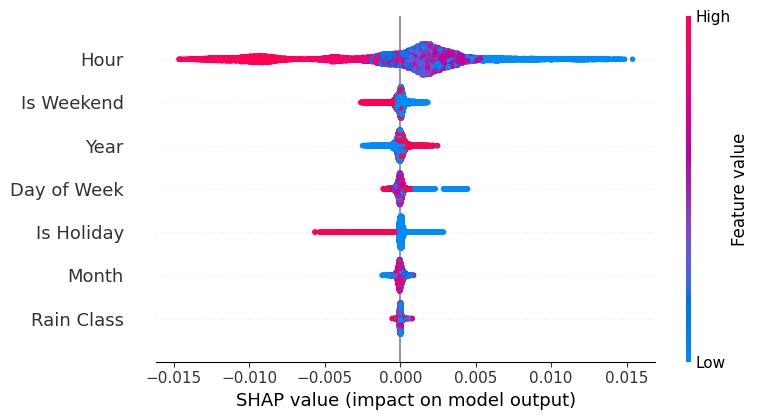

In [36]:
# Now the shapes should match
assert shap_values_avg.shape[1] == X_test_flat.shape[1], \
    f"SHAP values shape: {shap_values_avg.shape[1]}, X_test_flat shape: {X_test_flat.shape[1]}"

# Define feature names according to your dataset (excluding 'Entry')
feature_names = ['Hour', 'Day of Week', 'Is Weekend', 'Is Holiday', 'Month', 'Year', 'Rain Class']

# Plot the SHAP summary with feature names
shap.summary_plot(shap_values_avg, X_test_flat, feature_names=feature_names)

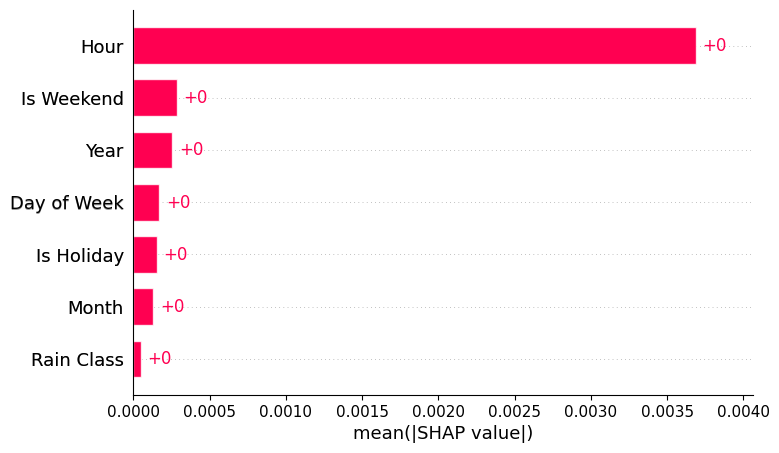

In [37]:
# Create an Explanation object
shap_explanation = shap.Explanation(values=shap_values_avg, feature_names=feature_names, data=X_test_flat)

# Plot the SHAP values
shap.plots.bar(shap_explanation)

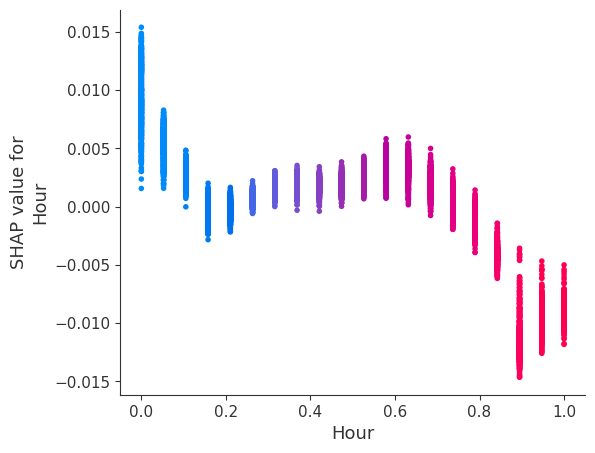

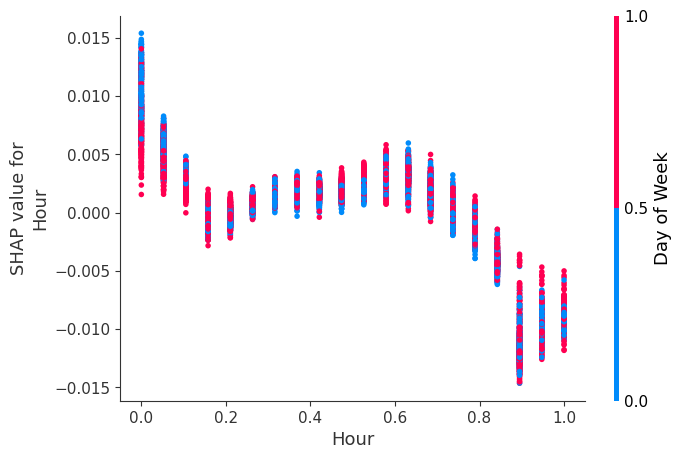

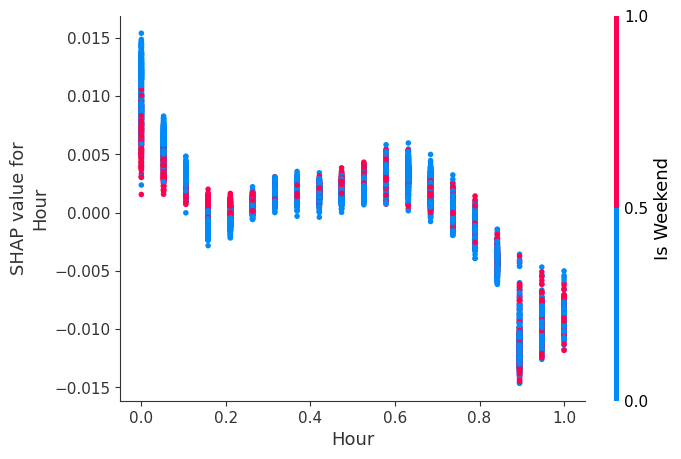

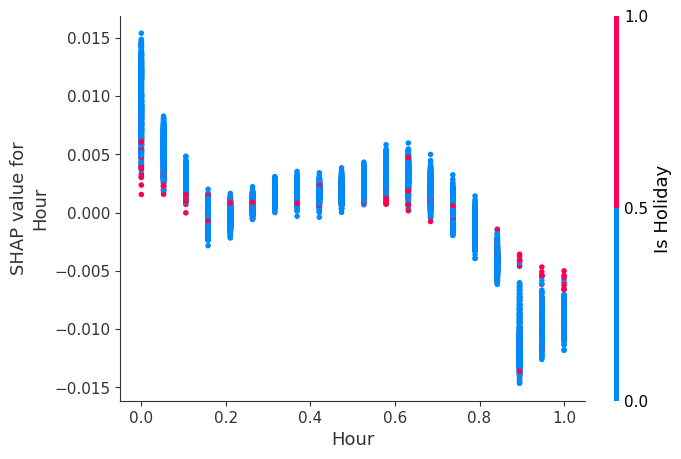

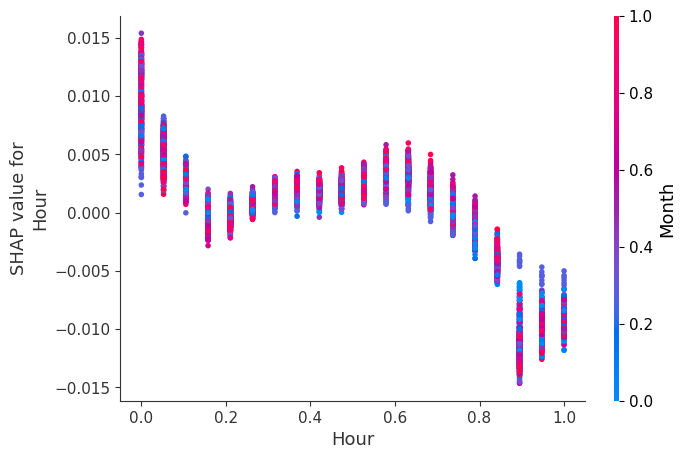

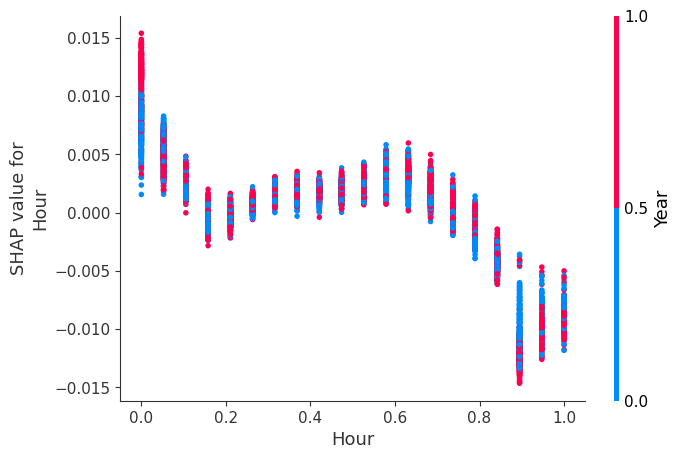

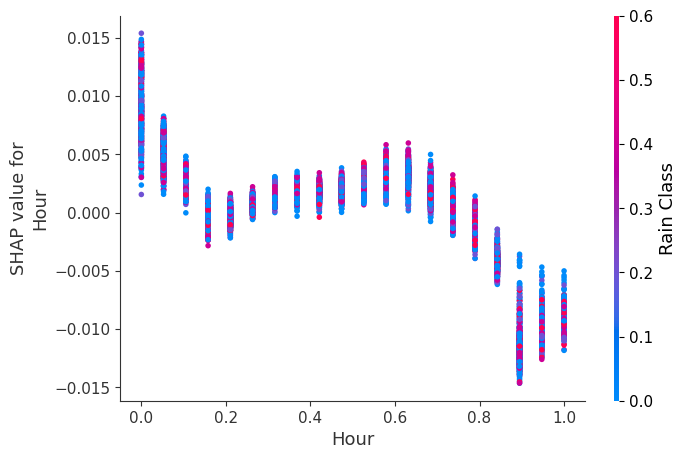

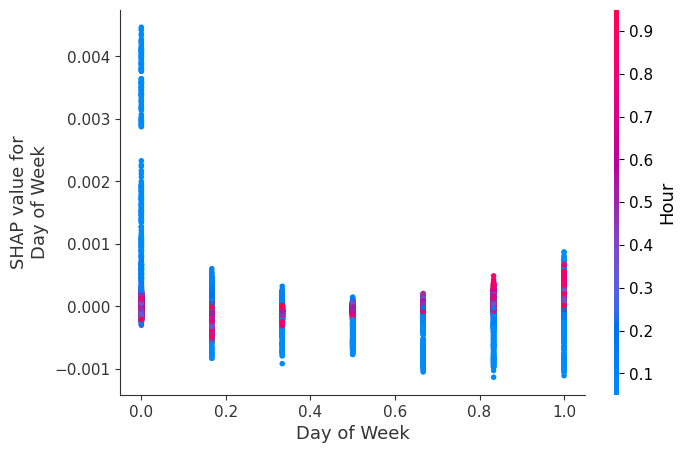

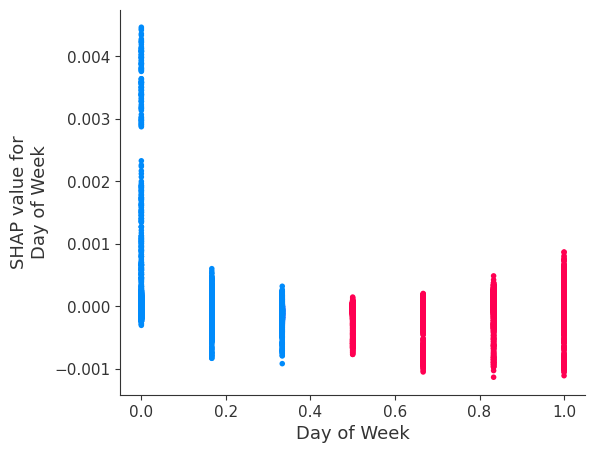

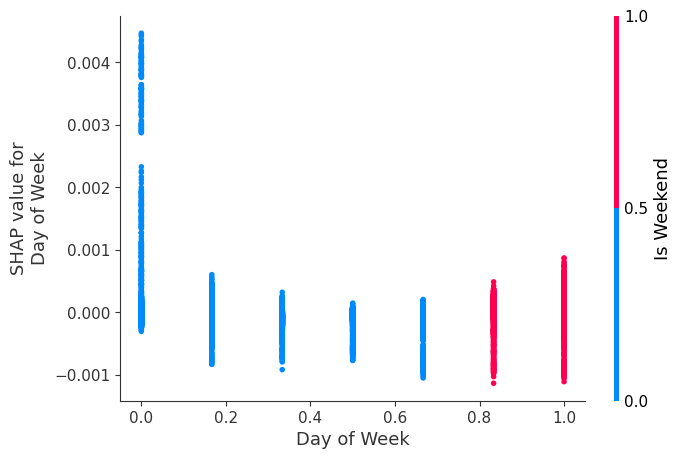

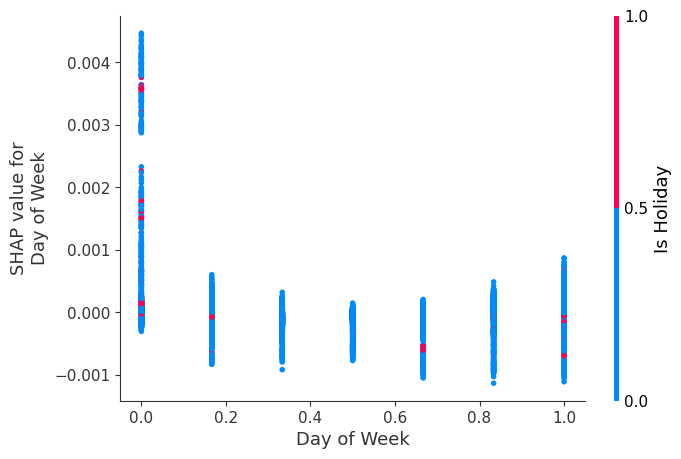

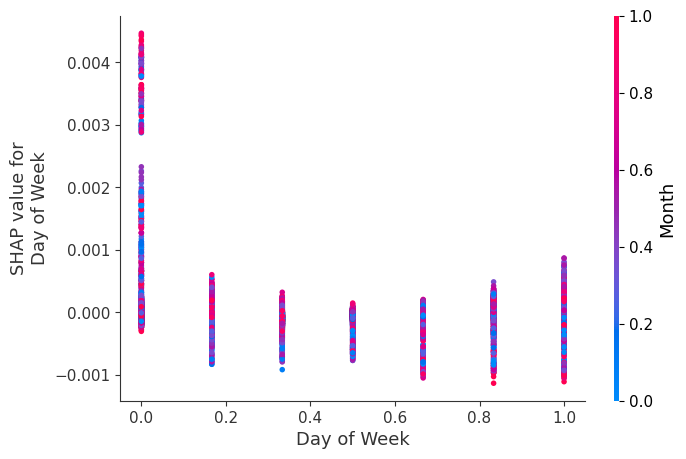

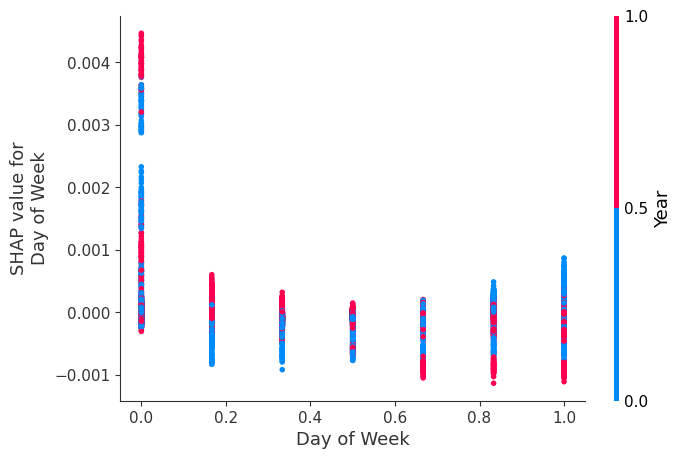

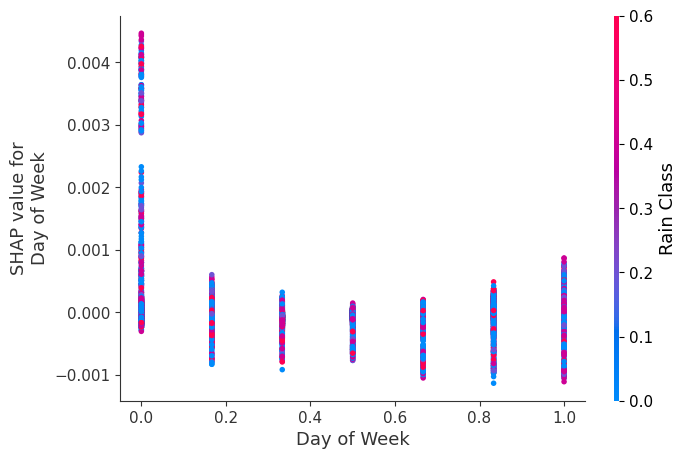

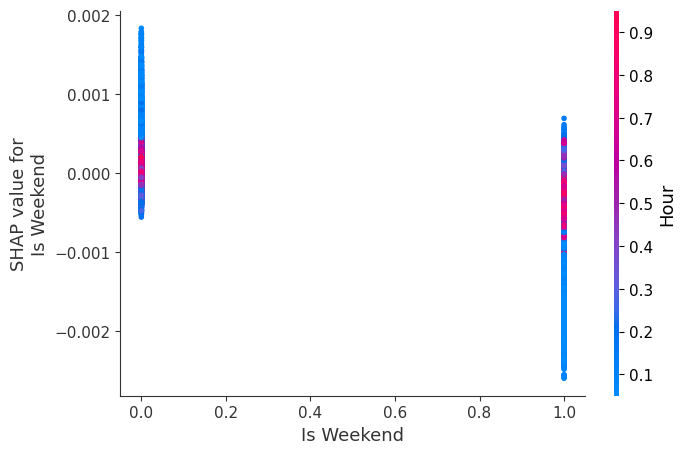

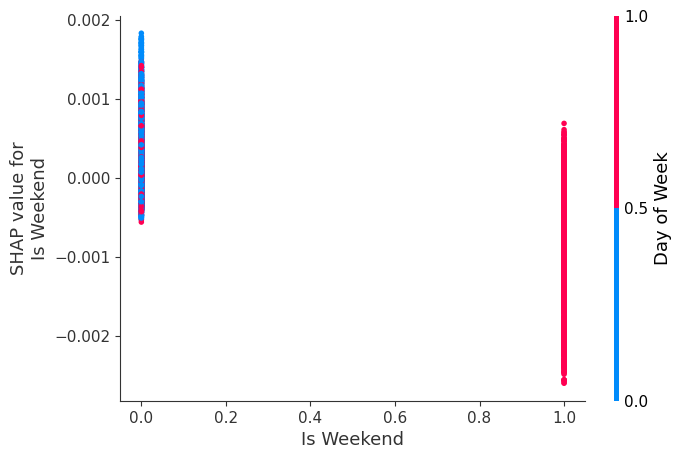

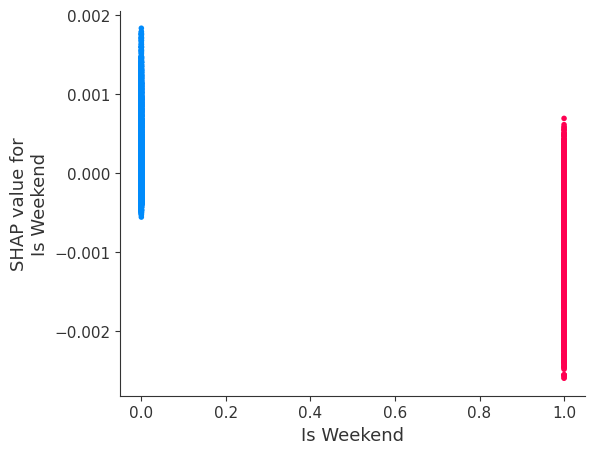

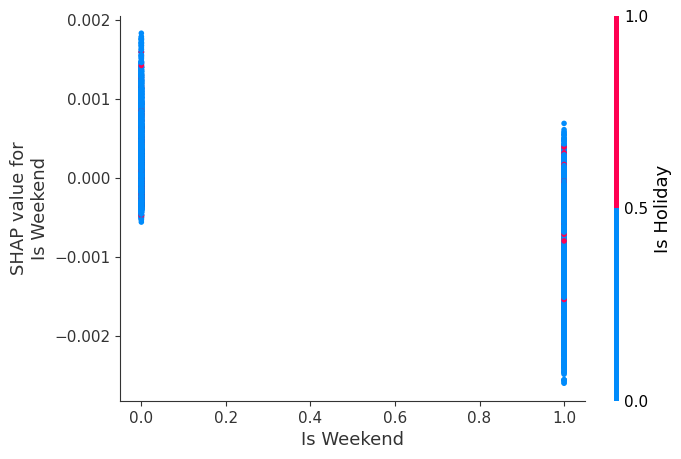

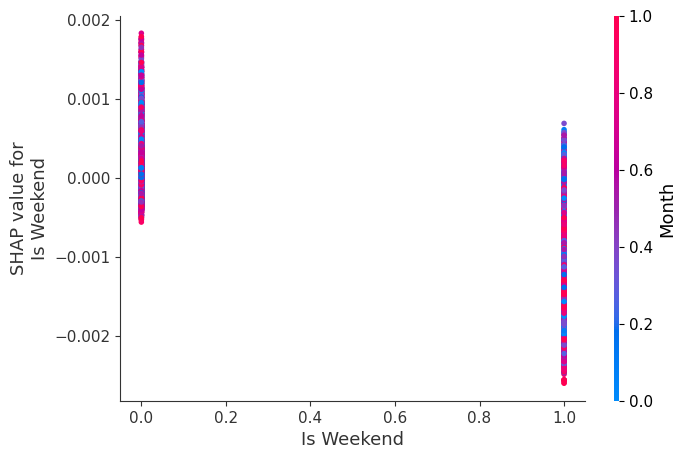

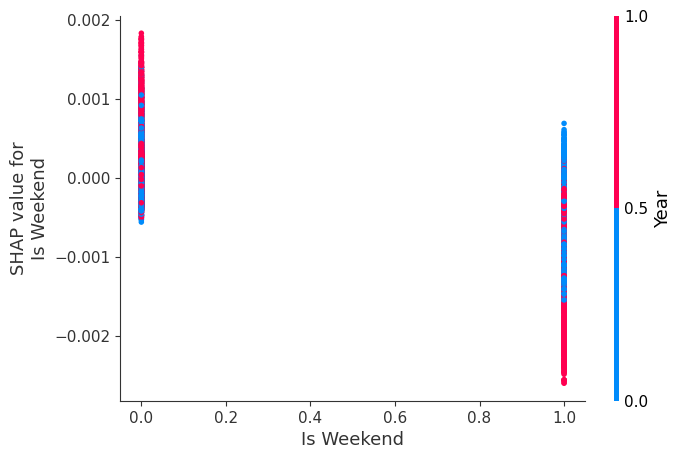

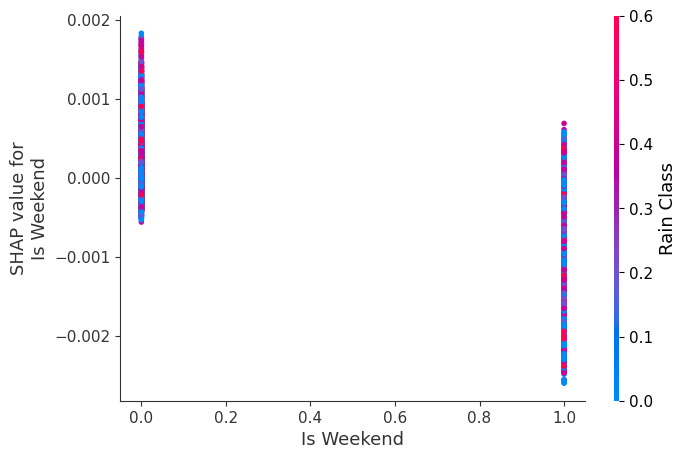

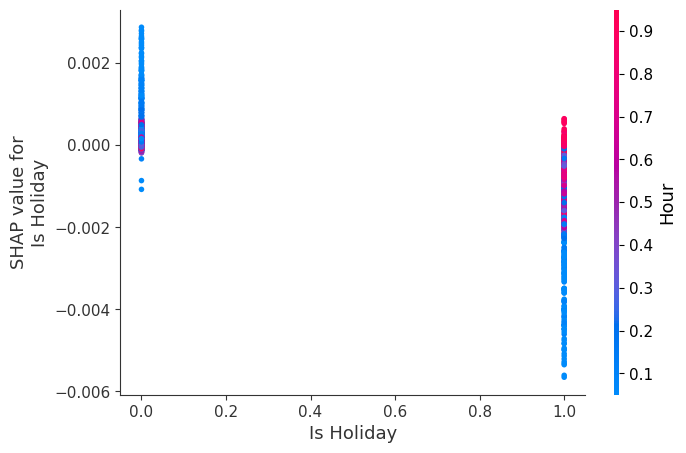

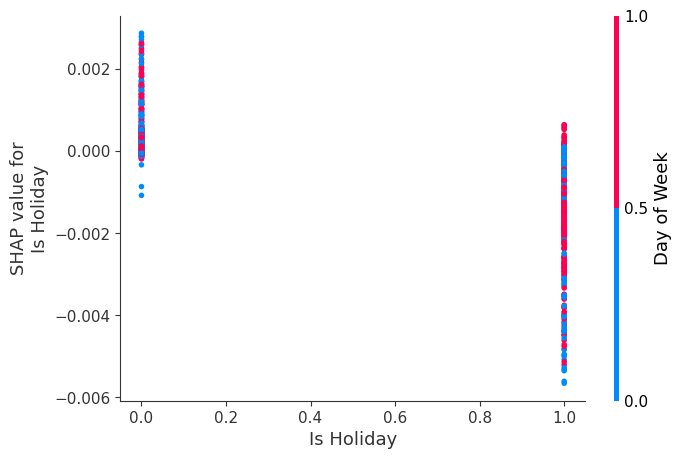

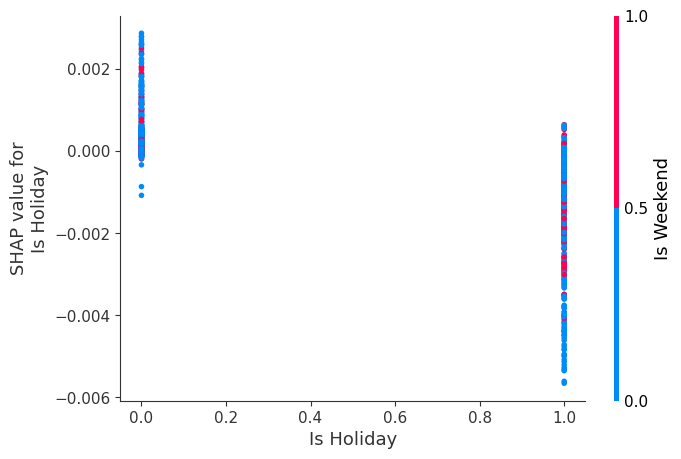

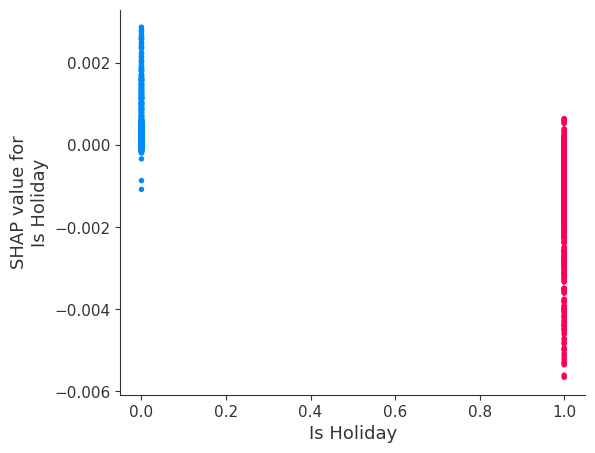

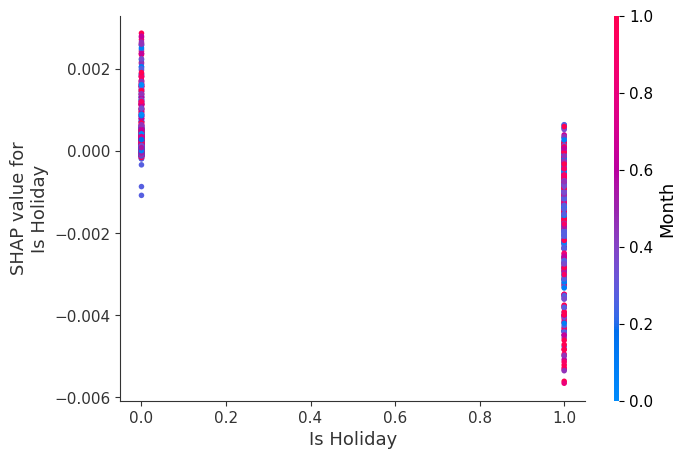

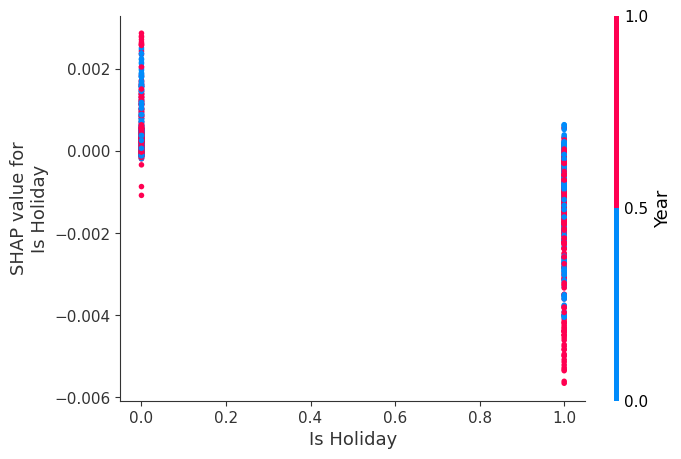

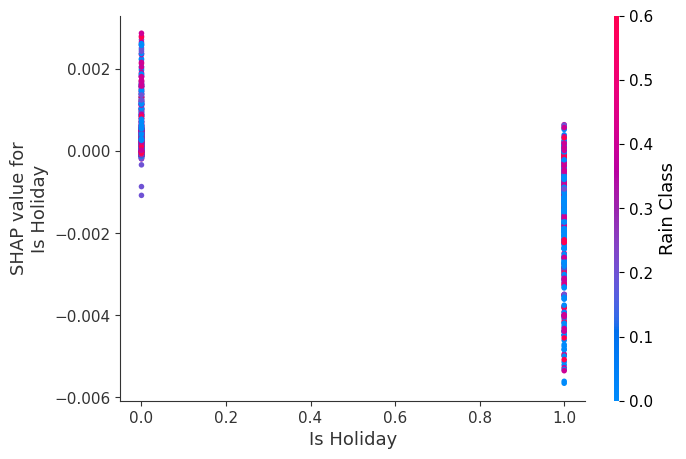

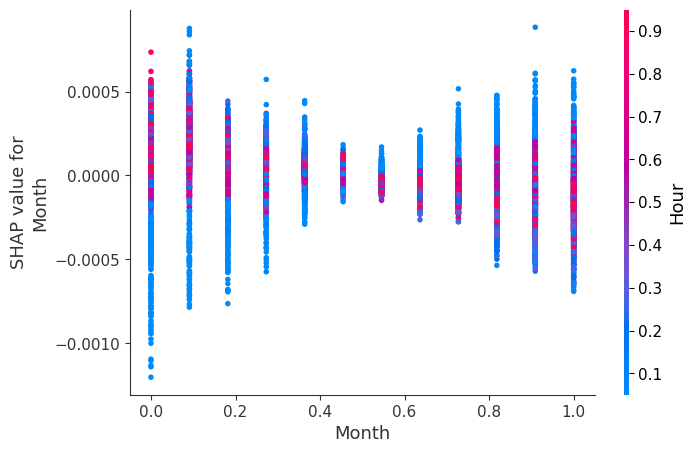

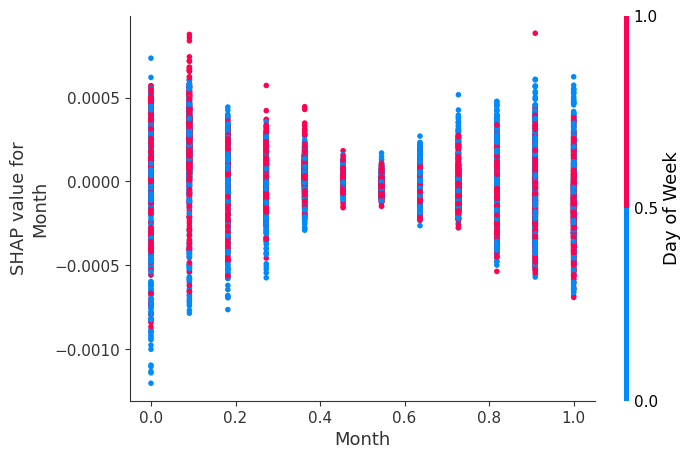

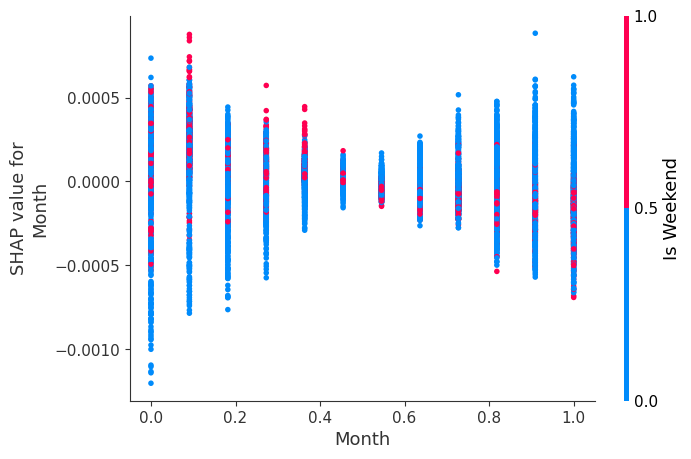

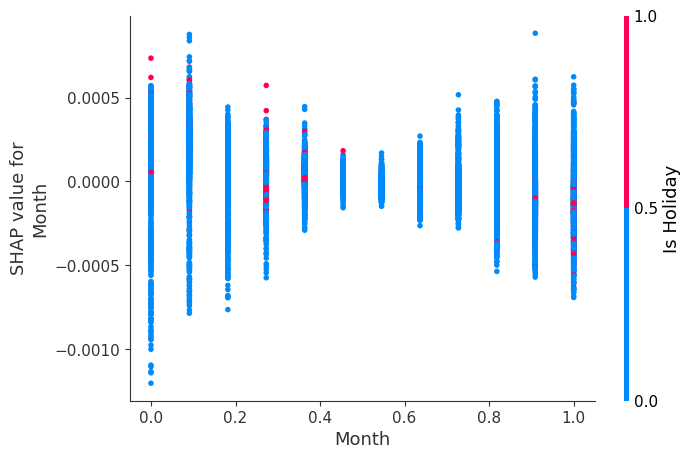

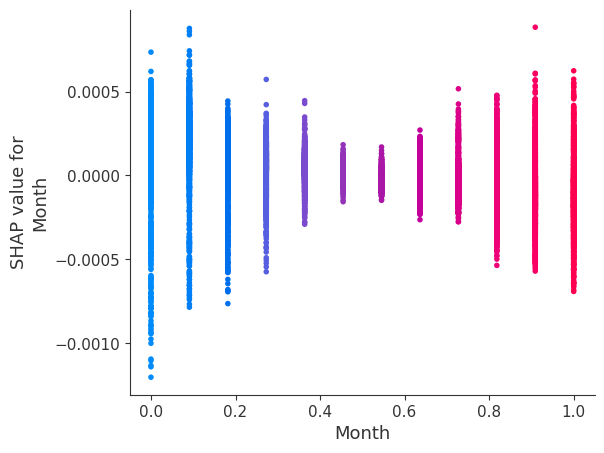

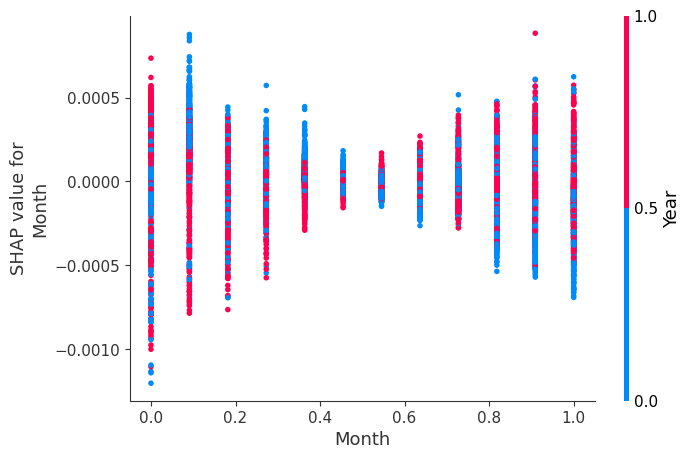

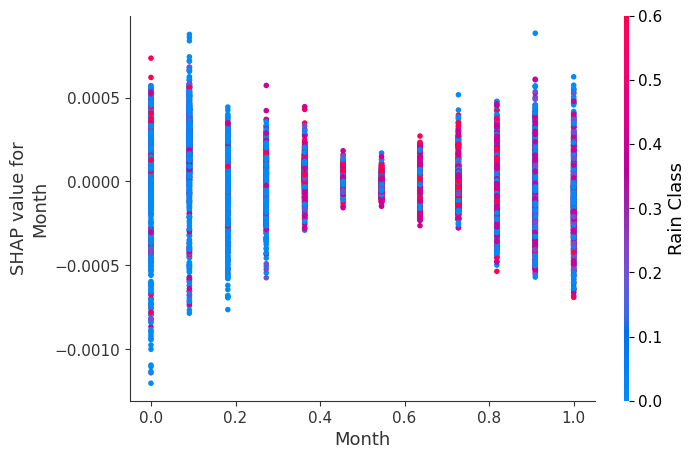

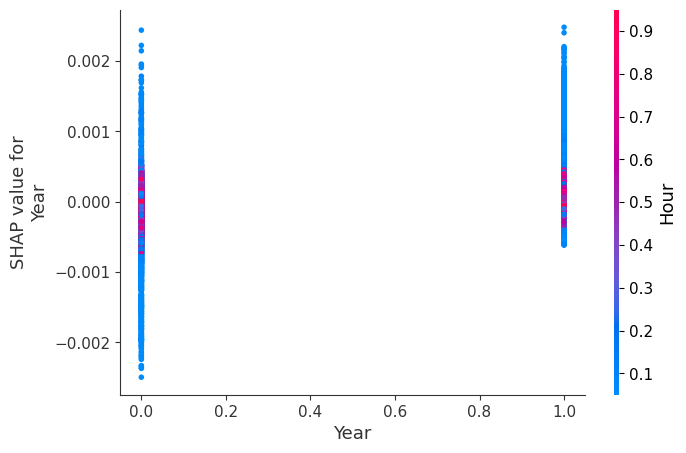

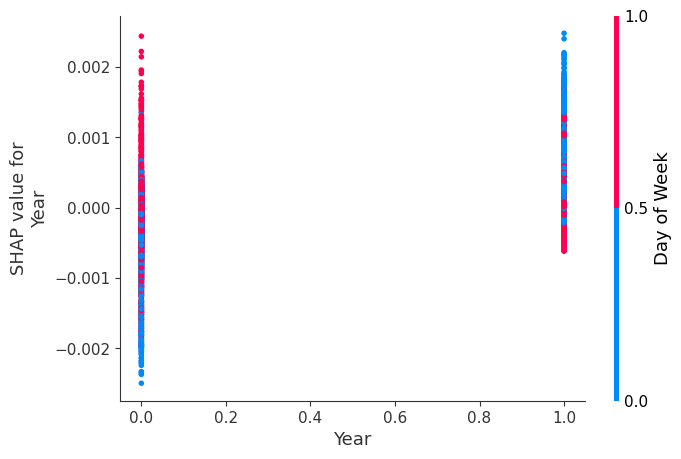

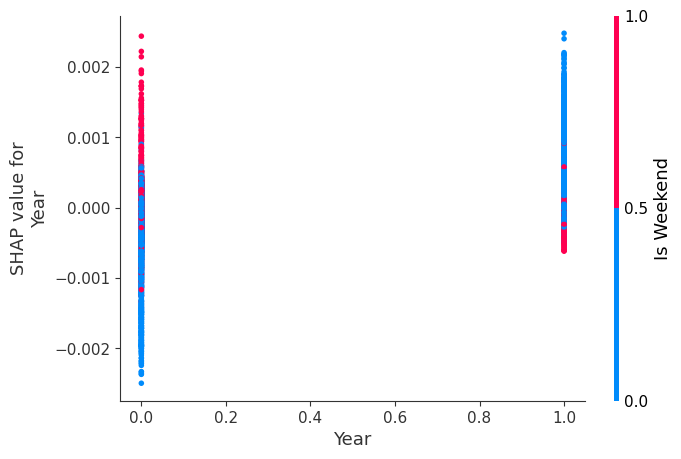

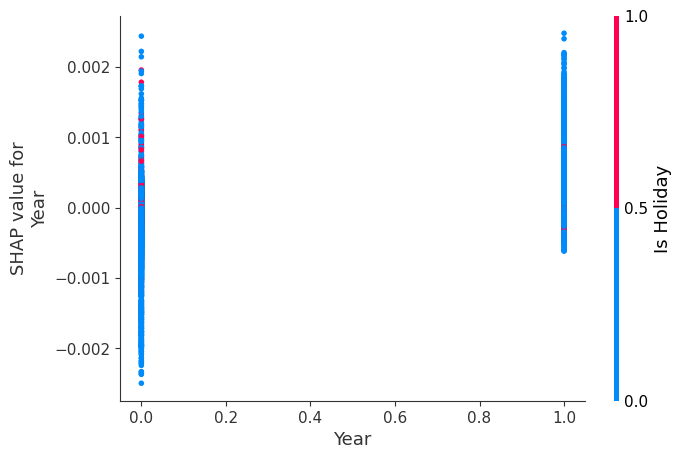

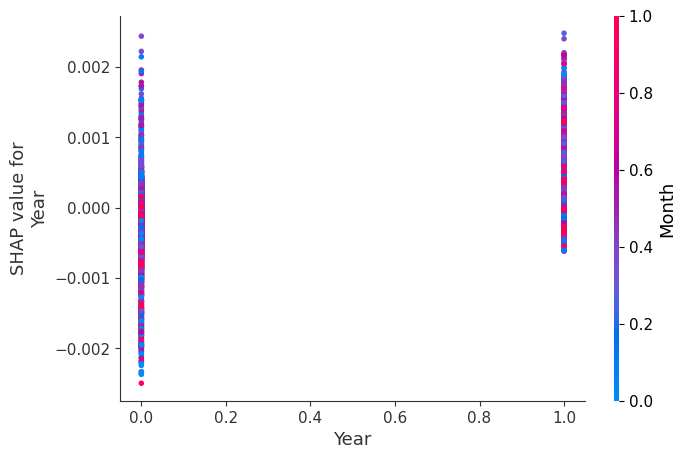

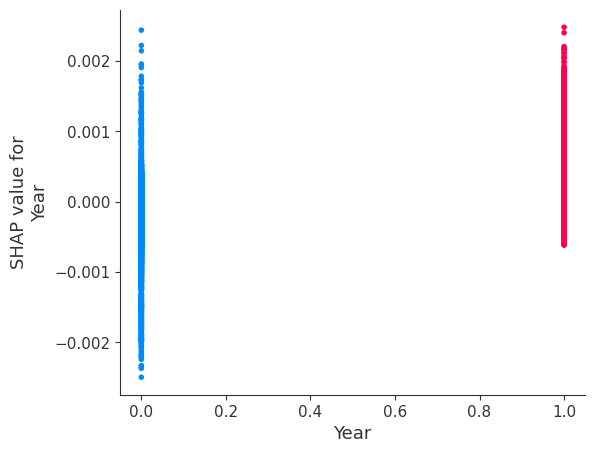

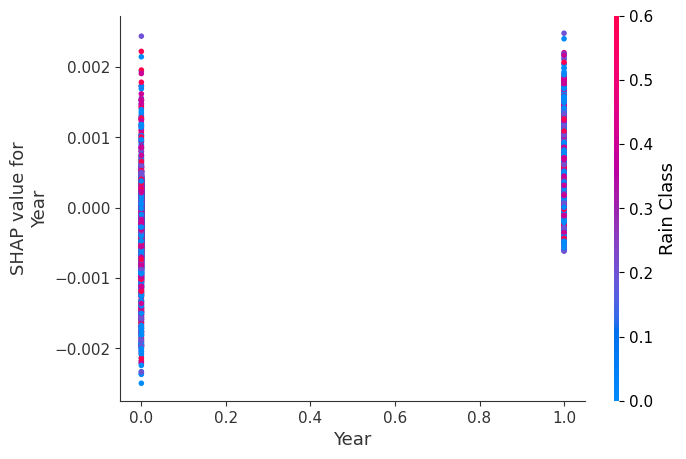

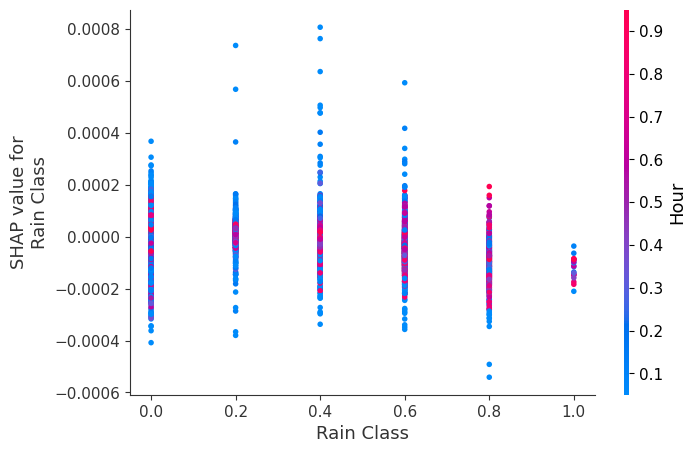

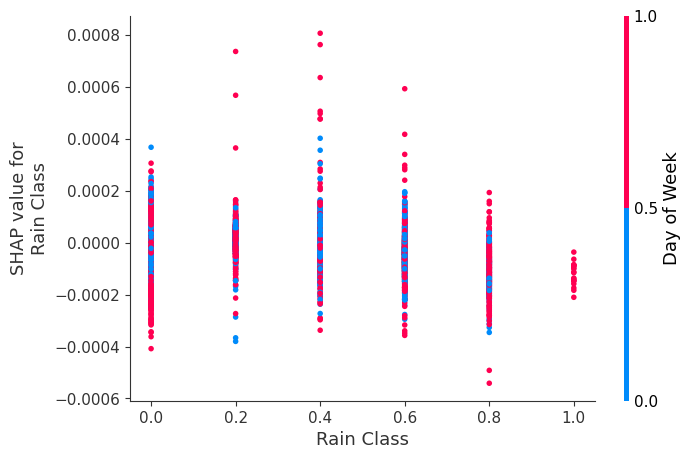

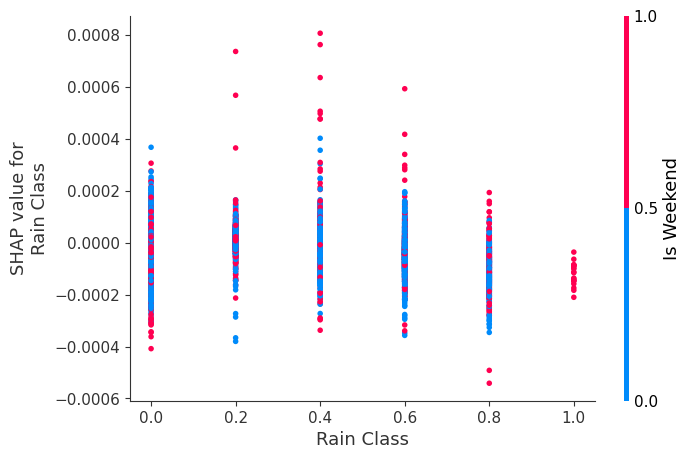

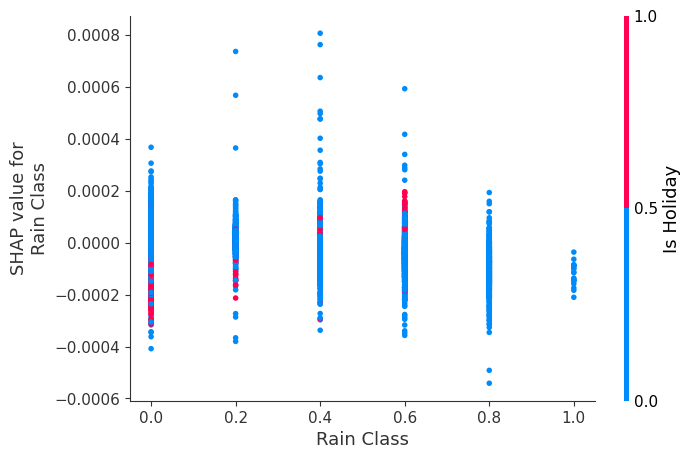

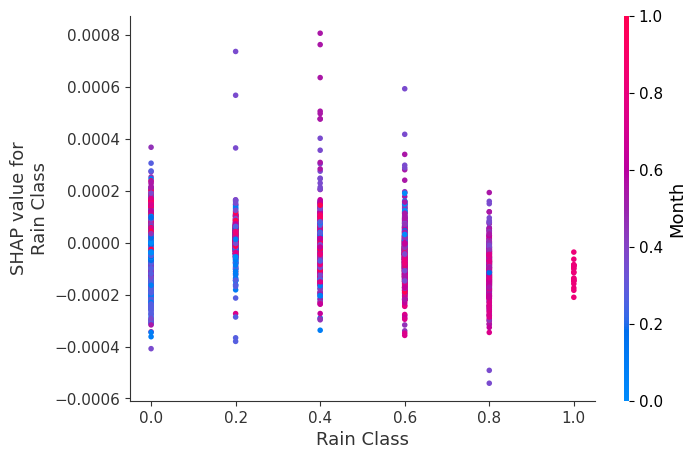

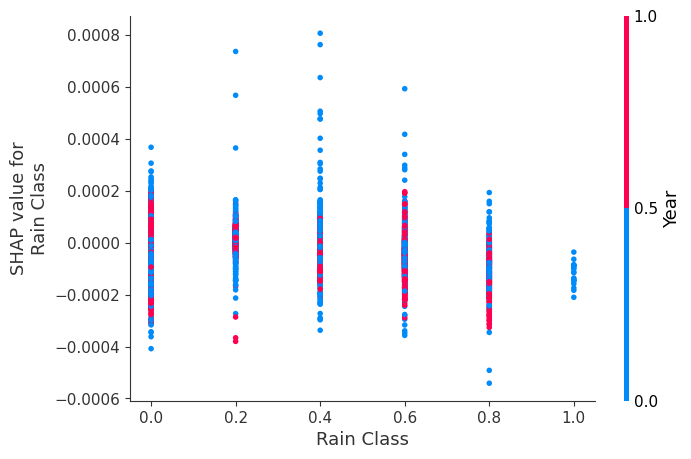

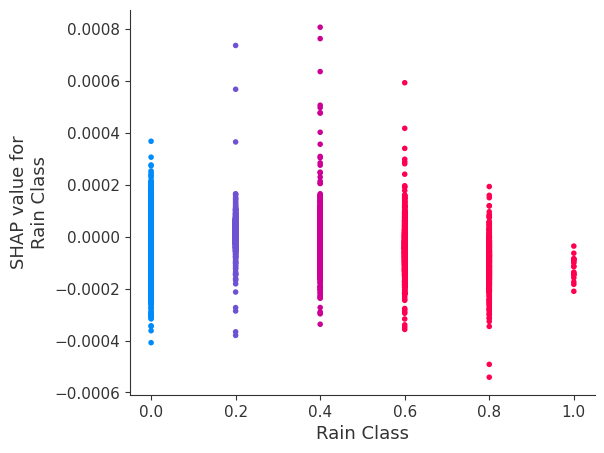

In [38]:
# 2. Plot SHAP Dependence Plot for the first feature (Hour)
for i in range(7):
    for j in range(7):
        shap.dependence_plot(i, shap_values_avg, X_test_flat, feature_names=feature_names, interaction_index=j)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


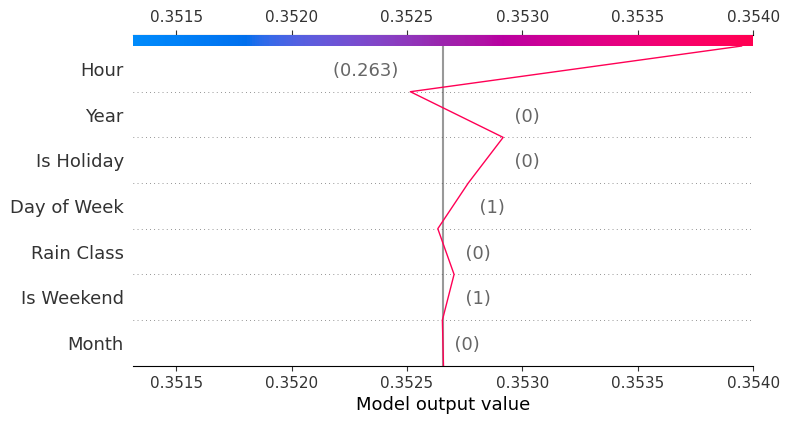

In [39]:
# Calculate the expected value for the model
expected_value = np.mean(model.predict(background))

# 3. Plot SHAP Decision Plot for the first prediction (the last time step)
shap.decision_plot(expected_value, shap_values_avg[6], X_test_flat[6], feature_names=feature_names)


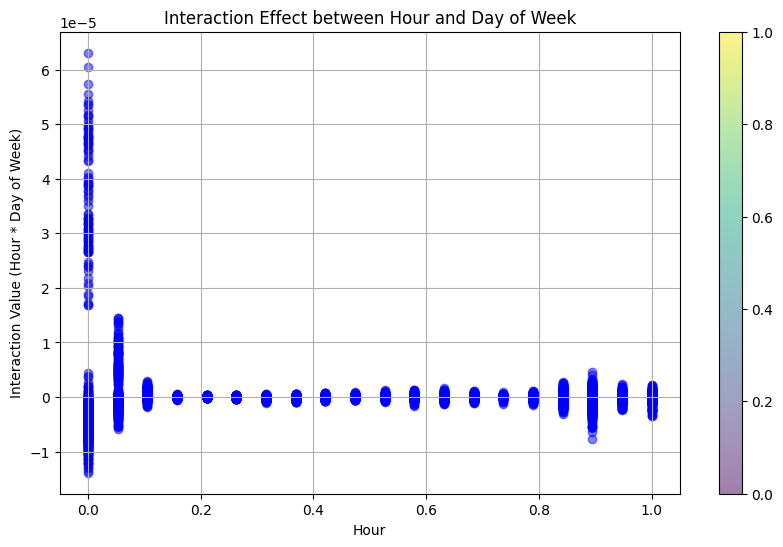

In [40]:
# 5. Manually calculate and plot interaction effects for the first two features (Hour and Day of Week)
# Note: This is a manual workaround, assuming interaction effects are calculated based on shap values
interaction_values = shap_values_avg[:, 0] * shap_values_avg[:, 1]  # Replace 0 and 1 with the indices of features you want to analyze
plt.figure(figsize=(10, 6))
plt.scatter(X_test_flat[:, 0], interaction_values, c='blue', alpha=0.5)
plt.colorbar()
plt.xlabel('Hour')
plt.ylabel('Interaction Value (Hour * Day of Week)')
plt.title('Interaction Effect between Hour and Day of Week')
plt.grid()
plt.show()

In [41]:
'''# Create a background dataset for SHAP using a larger sample from the training set
background = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Select a specific instance from X_test
instance_index = 0  # Change this index to select different instances
instance = X_test[instance_index:instance_index + 1]

# Compute SHAP values for the specific instance
shap_values_instance = explainer.shap_values(instance)

# Reshape the SHAP values to (n_timesteps, n_features) for the selected instance
shap_values_instance_flat = shap_values_instance.reshape(1, 8)  # Assuming 19 timesteps and 8 features

# Average SHAP values across time steps (or you can pick one specific time step)
shap_values_instance_avg = np.mean(shap_values_instance_flat, axis=0)  # Averaging over time steps
print("Averaged SHAP values shape for the instance:", shap_values_instance_avg.shape)

# Prepare the corresponding feature values (excluding the 'Entry' target variable)
instance_features = instance[:, -1, :-1]  # Take the last time step and exclude 'Entry'
print("Instance feature values shape:", instance_features.shape)

# Define feature names according to your dataset (excluding 'Entry')
feature_names = ['Hour', 'Day of Week', 'Is Weekend', 'Is Holiday', 'Month', 'Year', 'Rain Class']

# Compute the model output for the selected instance
model_output = model(instance)  # Get the model's predicted output for the instance

# Plot the SHAP waterfall plot for the specific instance
shap.waterfall_plot(
    shap.Explanation(values=shap_values_instance_avg[:-1],  # Exclude the 'Entry' SHAP value
                     base_values=model_output.numpy()[0],  # Use the model's output as the base value
                     data=instance_features[0],  # Feature values for this instance
                     feature_names=feature_names)
)'''



'# Create a background dataset for SHAP using a larger sample from the training set\nbackground = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]\n\n# Initialize SHAP GradientExplainer\nexplainer = shap.GradientExplainer(model, background)\n\n# Select a specific instance from X_test\ninstance_index = 0  # Change this index to select different instances\ninstance = X_test[instance_index:instance_index + 1]\n\n# Compute SHAP values for the specific instance\nshap_values_instance = explainer.shap_values(instance)\n\n# Reshape the SHAP values to (n_timesteps, n_features) for the selected instance\nshap_values_instance_flat = shap_values_instance.reshape(1, 8)  # Assuming 19 timesteps and 8 features\n\n# Average SHAP values across time steps (or you can pick one specific time step)\nshap_values_instance_avg = np.mean(shap_values_instance_flat, axis=0)  # Averaging over time steps\nprint("Averaged SHAP values shape for the instance:", shap_values_insta

In [42]:
# Load the scalers
scaler = joblib.load('model/scaler_features.pkl')
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Select a random starting index
random_start_index = np.random.randint(0, len(df_model) - 19)

# Select the next 19 rows starting from the random index
random_rows = df_model.iloc[random_start_index:random_start_index + 19]

# Inverse scale the selected rows
random_rows_inverse_scaled = random_rows.copy()
random_rows_inverse_scaled[random_rows.columns[:-1]] = scaler.inverse_transform(random_rows[random_rows.columns[:-1]])
random_rows_inverse_scaled['Entry'] = scaler_entry.inverse_transform(random_rows[['Entry']])


In [43]:
# Manually input the 20th row
manual_row = pd.DataFrame({
    'hour': [4],
    'day_of_week': [5],
    'is_weekend': [0],
    'is_holiday': [0],
    'month': [1],
    'year': [2030],
    'rain_class': [5],
    'Entry': [0]  # Placeholder for the entry value
})

In [44]:
# Combine the random rows and the manual row
input_df = pd.concat([random_rows_inverse_scaled, manual_row], ignore_index=True)

# Scale the input DataFrame
input_df_scaled = input_df.copy()
input_df_scaled[input_df.columns[:-1]] = scaler.transform(input_df[input_df.columns[:-1]])
input_df_scaled['Entry'] = scaler_entry.transform(input_df[['Entry']])  # Scale 'Entry'

# Prepare the input for the model
input_data = input_df_scaled.values.reshape((1, 20, -1))  # Adjust the shape to match the model's expected input

# Make predictions using the model
predictions = model.predict(input_data)

# Write the prediction to the 19th index of the DataFrame
input_df.at[19, 'Entry'] = scaler_entry.inverse_transform(predictions)[0, 0]
input_df.head(20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


hour  day_of_week  is_weekend  is_holiday  month    year  rain_class  \
0    9.0          4.0         0.0         0.0   11.0  2022.0         0.0   
1   10.0          4.0         0.0         0.0   11.0  2022.0         0.0   
2   11.0          4.0         0.0         0.0   11.0  2022.0         0.0   
3   12.0          4.0         0.0         0.0   11.0  2022.0         0.0   
4   13.0          4.0         0.0         0.0   11.0  2022.0         0.0   
5   14.0          4.0         0.0         0.0   11.0  2022.0         0.0   
6   15.0          4.0         0.0         0.0   11.0  2022.0         0.0   
7   16.0          4.0         0.0         0.0   11.0  2022.0         0.0   
8   17.0          4.0         0.0         0.0   11.0  2022.0         0.0   
9   18.0          4.0         0.0         0.0   11.0  2022.0         0.0   
10  19.0          4.0         0.0         0.0   11.0  2022.0         0.0   
11  20.0          4.0         0.0         0.0   11.0  2022.0         0.0   
12  21.0          4.0         0.0         0.0   11.0  2022.0         0.0   
13  22.0          4.0         0.0         0.0   11.0  2022.0         0.0   
14  23.0          4.0         0.0         0.0   11.0  2022.0         0.0   
15   4.0          5.0         1.0         0.0   11.0  2022.0         2.0   
16   5.0          5.0         1.0         0.0   11.0  2022.0         2.0   
17   6.0          5.0         1.0         0.0   11.0  2022.0         2.0   
18   7.0          5.0         1.0         0.0   11.0  2022.0         2.0   
19   4.0          5.0         0.0         0.0    1.0  2030.0         5.0   

          Entry  
0   2579.000000  
1   2172.000000  
2   1973.000000  
3   2190.000000  
4   2155.000000  
5   2199.000000  
6   2187.000000  
7   2748.000000  
8   3196.000000  
9   2999.000000  
10   907.000000  
11  2779.000000  
12  1733.000000  
13   127.000000  
14     0.000000  
15     0.000000  
16  1167.000000  
17  1897.000000  
18  2079.000000  
19  2216.237061

In [45]:
print("Scaled input_df before prediction:")
print(input_df_scaled)


Scaled input_df before prediction:
        hour  day_of_week  is_weekend  is_holiday     month  year  rain_class  \
0   0.263158     0.666667         0.0         0.0  0.909091   0.0         0.0   
1   0.315789     0.666667         0.0         0.0  0.909091   0.0         0.0   
2   0.368421     0.666667         0.0         0.0  0.909091   0.0         0.0   
3   0.421053     0.666667         0.0         0.0  0.909091   0.0         0.0   
4   0.473684     0.666667         0.0         0.0  0.909091   0.0         0.0   
5   0.526316     0.666667         0.0         0.0  0.909091   0.0         0.0   
6   0.578947     0.666667         0.0         0.0  0.909091   0.0         0.0   
7   0.631579     0.666667         0.0         0.0  0.909091   0.0         0.0   
8   0.684211     0.666667         0.0         0.0  0.909091   0.0         0.0   
9   0.736842     0.666667         0.0         0.0  0.909091   0.0         0.0   
10  0.789474     0.666667         0.0         0.0  0.909091   0.0         

In [46]:
print("Predicted value (before inverse scaling):", predictions)
print("Predicted value (after inverse scaling):", scaler_entry.inverse_transform(predictions))


Predicted value (before inverse scaling): [[0.34666622]]
Predicted value (after inverse scaling): [[2216.237]]


In [47]:
# Check if the scaled values are within a reasonable range
print("Scaled manual row before prediction:")
print(input_df_scaled.iloc[-1])  # Print the last row (manual input row)

# Check if the model outputs a reasonable scaled prediction
prediction_scaled = model.predict(input_data)
print("Scaled prediction:", prediction_scaled)

# Inverse scale the prediction
prediction_inverse = scaler_entry.inverse_transform(prediction_scaled)
print("Inverse-scaled prediction:", prediction_inverse)


Scaled manual row before prediction:
hour           0.000000
day_of_week    0.833333
is_weekend     0.000000
is_holiday     0.000000
month          0.000000
year           8.000000
rain_class     1.000000
Entry          0.000000
Name: 19, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Scaled prediction: [[0.34666622]]
Inverse-scaled prediction: [[2216.237]]
